## RAG (Retrieval Augmented Generation)

**Why we Need RAG System**

Large Language Models (LLMs) demonstrate significant capabilities but sometimes generate incorrect but believable responses when they lack information, and this is known as “hallucination.” It means they confidently provide information that may sound accurate but could be incorrect due to outdated knowledge.

LLMs can reason about wide-ranging topics, but their knowledge is limited to the public data up to a specific point in time that they were trained on. If you want to build AI applications that can reason about private data or data introduced after a model's cutoff date, you need to augment the knowledge of the model with the specific information it needs. The process of bringing the appropriate information and inserting it into the model prompt is known as Retrieval Augmented Generation (RAG).

**How It Solves the Problem**

Retrieval-Augmented Generation or RAG framework solves this problem by integrating an information retrieval system into the LLM pipeline. Instead of relying on pre-trained knowledge, RAG allows the model to dynamically fetch information from external knowledge sources when generating responses. This dynamic retrieval mechanism ensures that the information provided by the LLM is not only contextually relevant but also accurate and up-to-date.

It is a more efficient way to provide additional or domain-specific information using an external database, rather than repeatedly retraining or fine-tuning the model on updated data. It bridges the gap between pure generative models and external knowledge. 




**main components:**

* Indexing: a pipeline for ingesting data from a source and indexing it. This usually happens offline.

* Retrieval and generation: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model. After the llm model generate output based on pretrained knowledge & external data.*

**Advanced Terms**

* Query Translation: Multiple strategies for translating and refining queries are discussed, including Multi-Query techniques, RAG Fusion, Decomposition, Step Back, and HyDE approaches, each offering unique benefits depending on the application.

* Routing, Query Construction, and Advanced Indexing Techniques: These segments explore more sophisticated elements of RAG systems, such as routing queries to appropriate models, constructing effective queries, and advanced indexing techniques like RAPTOR and ColBERT.

* CRAG and Adaptive RAG: The course also introduces CRAG (Conditional RAG) and Adaptive RAG, enhancements that provide even more flexibility and power to the standard RAG framework.

* Is RAG Really Dead?: Finally, a discussion on the current and future relevance of RAG in research and practical applications, stimulating critical thinking and exploration beyond the course.

## Indexing

* Load: First we need to load our data. This is done with Document Loaders.

* Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit in a model's finite context window.

* Store: We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.

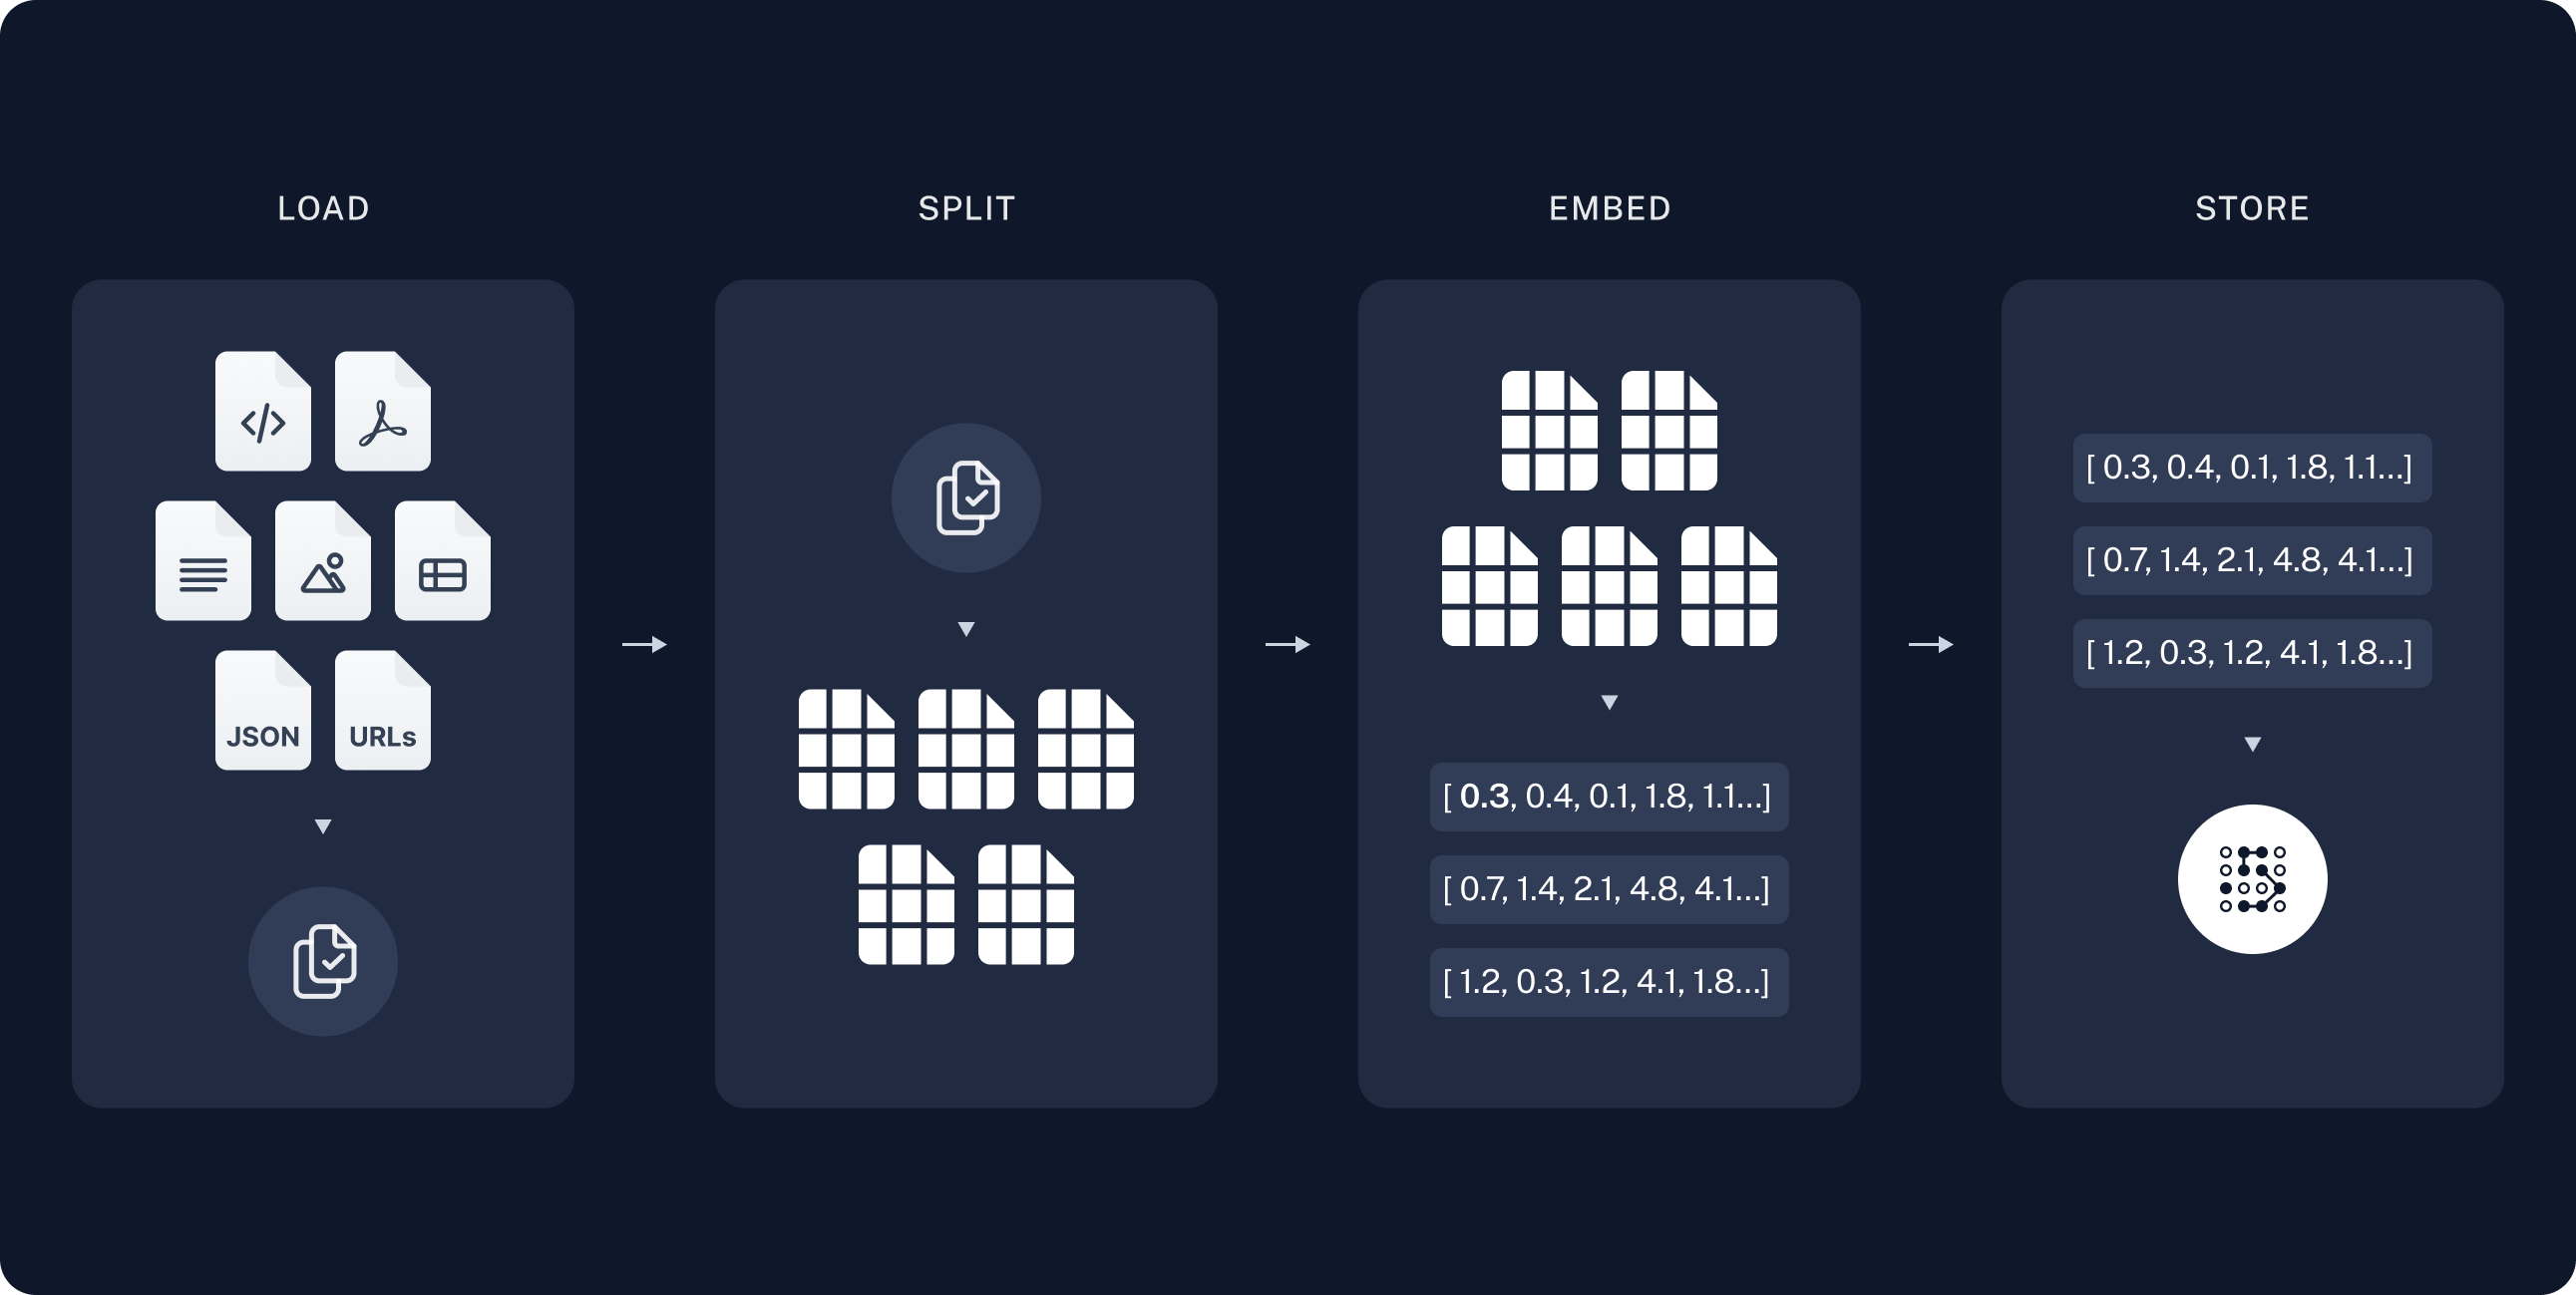

### Retrieval and generation
* Retrieve: Given a user input, relevant splits are retrieved from storage using a Retriever.
* Generate: A ChatModel / LLM produces an answer using a prompt that includes the question and the retrieved data

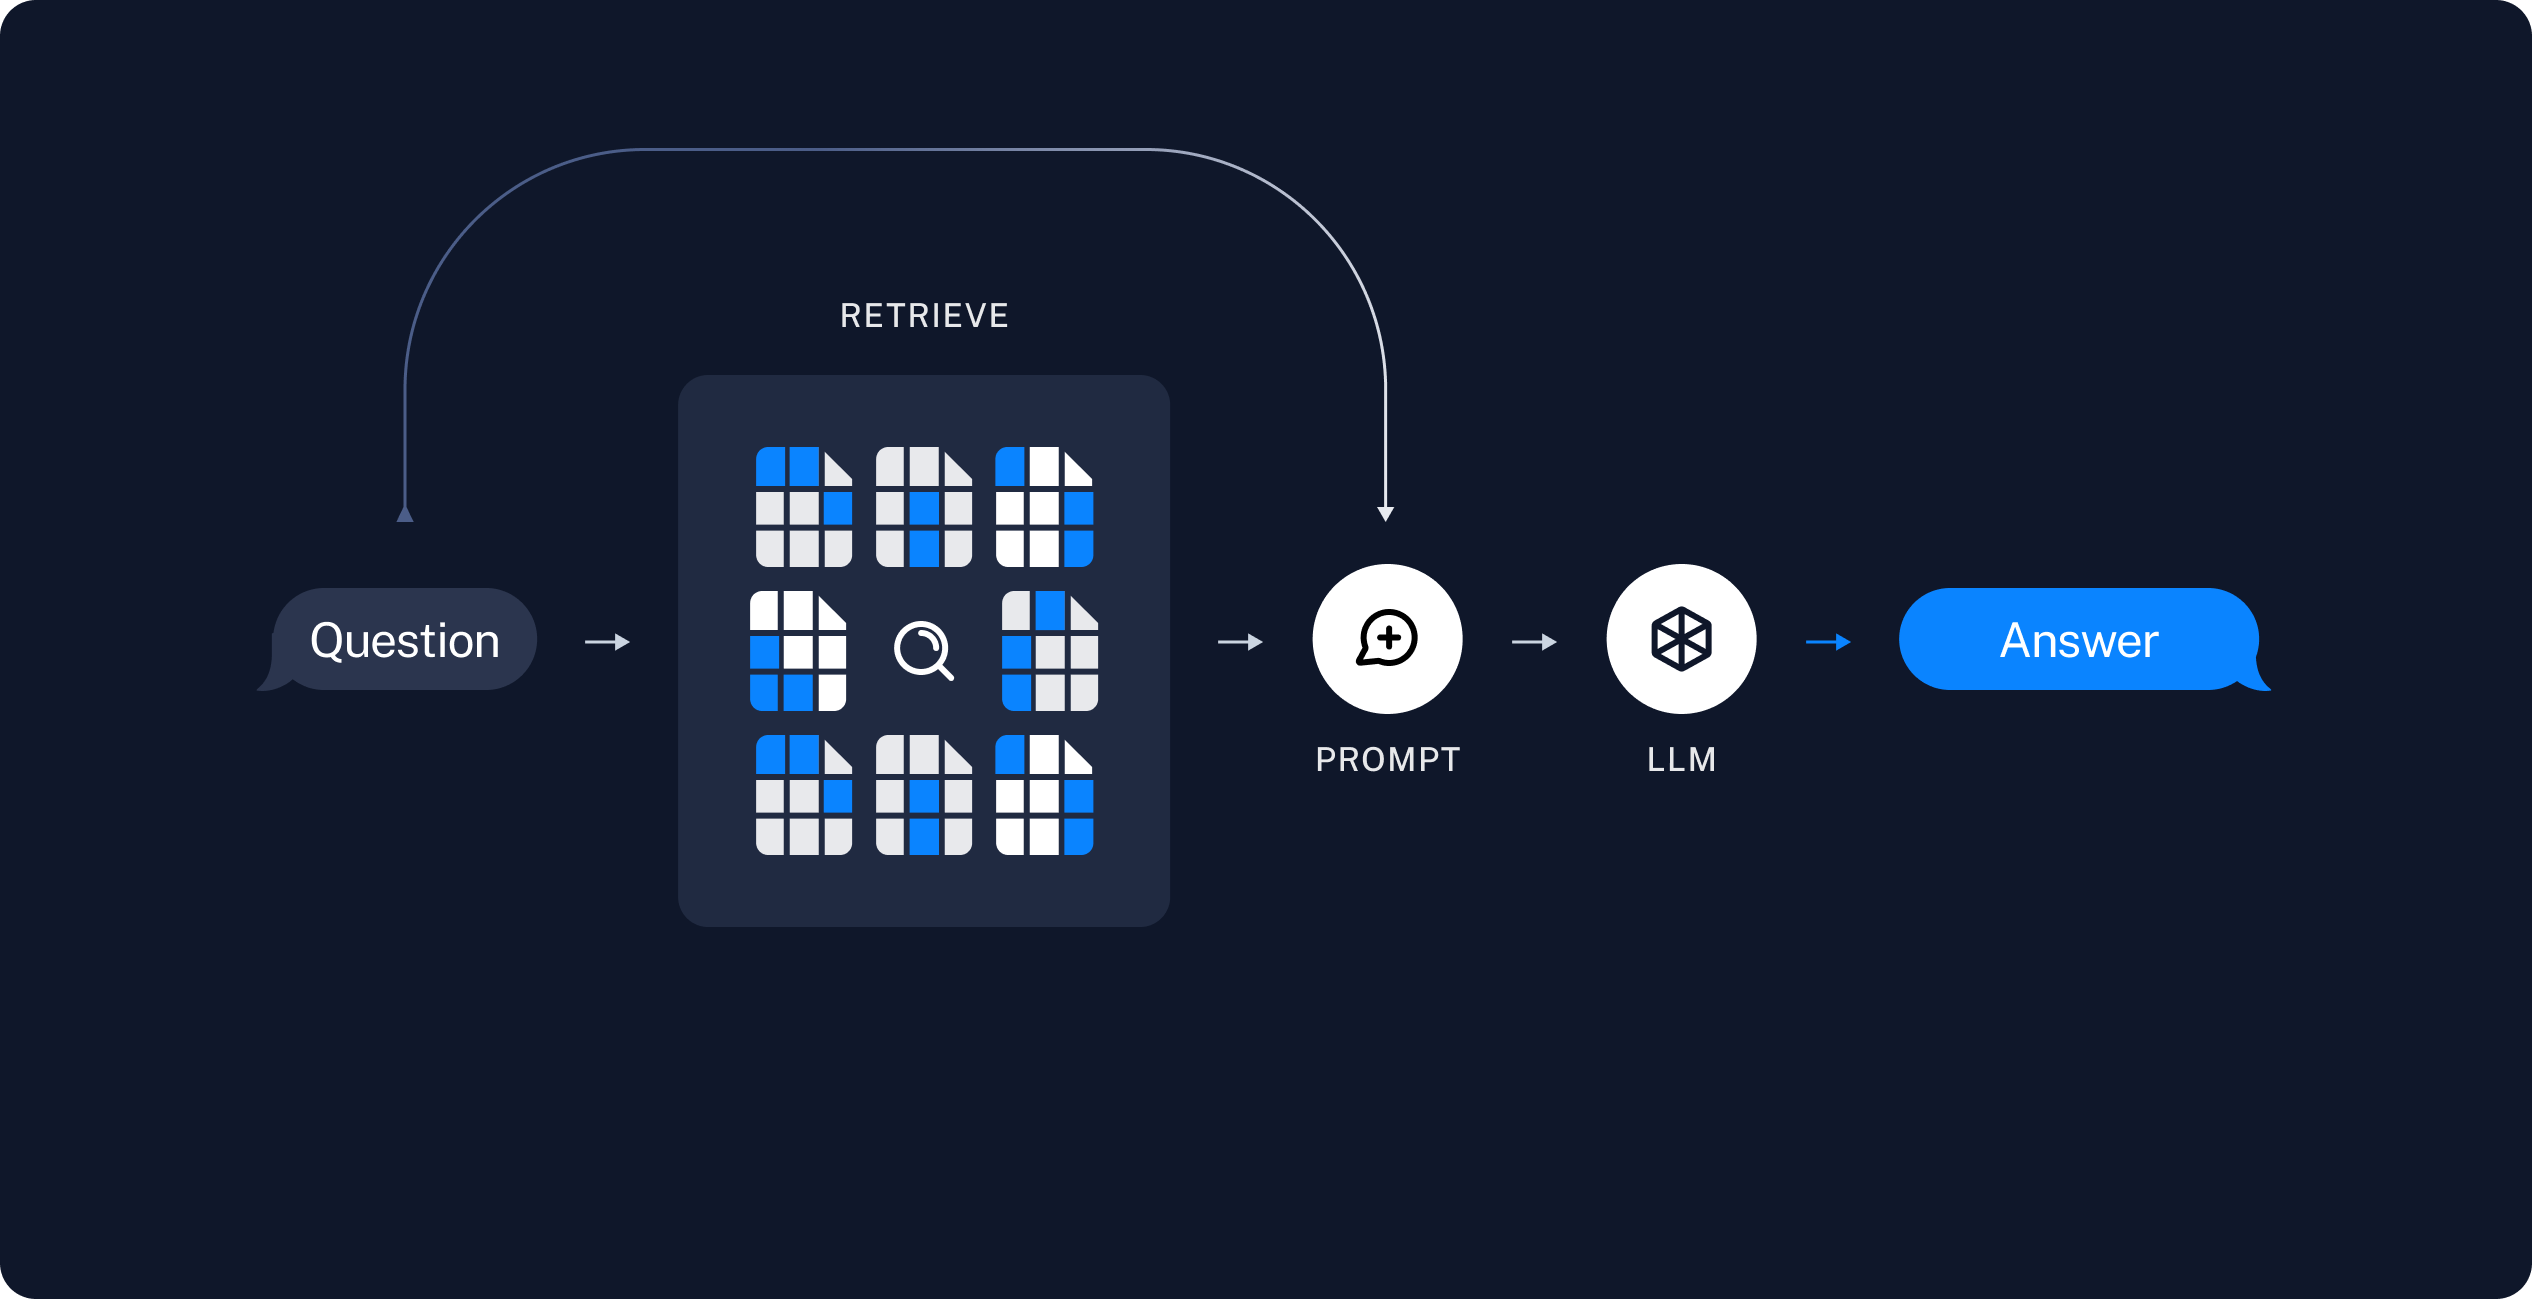

## Full Architecture

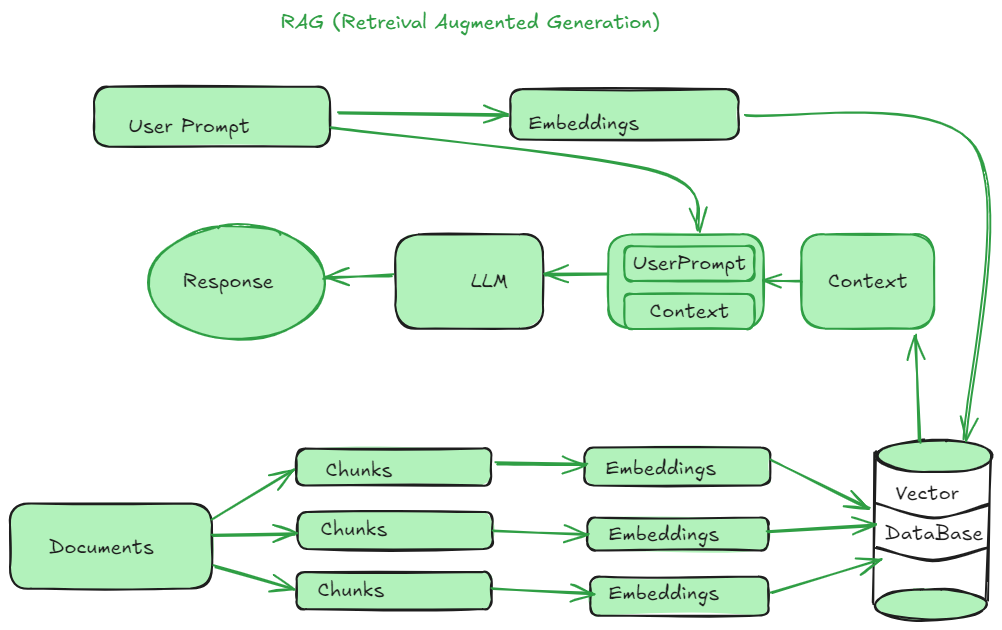

**Techniques to perform a RAG Applications**
* Document Loaders
* Text Splitting
* Embeddings
* Vector Stores
* Retrievals
* Key Value Stores

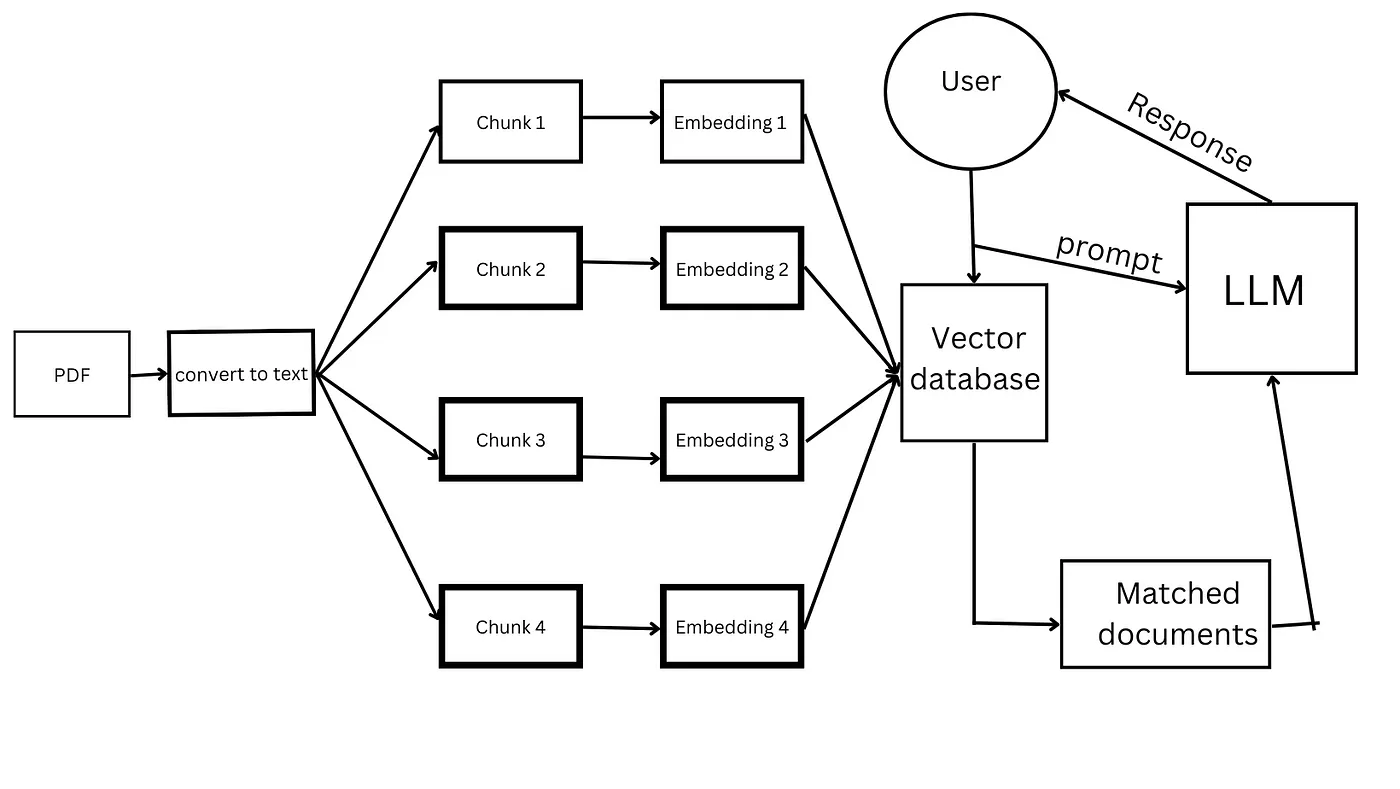

### Let's create a RAG application through LangChain

* Load the model
* Load Documents
* Split the Documents into multiple small chunks
* Perform Embeddings & store into Vector Database
* Retrieve chunks from Database based on User Question
* User Questions & retrieved contexts are sent to Prompt Templates
* Send Prompt Template to LLM & Generate response

In [1]:
# Import necessary libraries
from langchain_core.output_parsers import StrOutputParser
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

**Load the LLM Model**

In [27]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("GOOGLE_GEN_API")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0.3, api_key=api_key)
llm.invoke("what is langchain")

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


AIMessage(content='## LangChain: Building Powerful Applications with Large Language Models\n\nLangChain is a powerful and flexible framework designed to simplify the development of applications that leverage the capabilities of large language models (LLMs) like GPT-4, PaLM, and others. It goes beyond simple text generation and allows you to build more sophisticated and context-aware applications by combining LLMs with other computational or knowledge sources.\n\n**Here\'s a breakdown of what LangChain offers:**\n\n**1. Components:**\n\n* **Models:**  Connect to various LLMs and embedding models from providers like OpenAI, Hugging Face, and more.\n* **Prompts:** Manage and optimize your prompts with templates and techniques to elicit the desired responses from LLMs.\n* **Chains:** Combine multiple LLM calls or other tools in a specific sequence to perform complex tasks.\n* **Data Augmentation:** Use LLMs to generate synthetic data, rephrase text, or translate languages, enhancing your d

**Load Documents**

In [3]:
def load_documents(file_path):
    loader = PyPDFLoader(file_path)
    documents = loader.load()
    return documents

pdf_path = 'data/python book.pdf'

documents = load_documents(pdf_path)

**Split Documents**

In [4]:
# Split documents into smaller chunks
def split_documents(documents):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=10000, chunk_overlap=100)
    split_docs = text_splitter.split_documents(documents)
    print(len(split_docs))
    return split_docs

split_docs = split_documents(documents)

63


**Perform Embeddings & store the index into Vector Database**

In [9]:
#install faiss-cpu / faiss-gpu
from langchain.vectorstores import FAISS

def get_vector_store(text_chunks):
    texts = [chunk.page_content for chunk in text_chunks]  # Extract text content from the chunks
    embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001",google_api_key=api_key)
    vector_store = FAISS.from_texts(texts, embedding=embeddings)
    vector_store.save_local("faiss_index")

get_vector_store(split_docs)


# from langchain_chroma import Chroma
# embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001",google_api_key=api_key)
# vectorstore = Chroma.from_documents(documents=split_docs, embedding=embeddings)

Retrieve chunks from Database based on User Question

In [13]:
def retreive_context(user_question):
    embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001",google_api_key=api_key)
    new_db = FAISS.load_local("faiss_index", embeddings,allow_dangerous_deserialization=True)
    docs = new_db.similarity_search(user_question)
    print(docs)
    return docs

retreive_context("Which topics are covered in the book")

[Document(metadata={}, page_content='Page 2 of 63 Table of Contents 1 Chapter 1 - Introduction.....................................................................................................6 2 Chapter 2 - Resources Required for the Course.................................................................8 2.1 Programming Language.............................................................................................8 2.2 Computer Operating Systems....................................................................................8 2.3 Additional Libraries (Modules).................................................................................8 2.4 Editors........................................................................................................................9 2.5 Where to do the Work................................................................................................9 2.6 Books.........................................................................

[Document(metadata={}, page_content='Page 2 of 63 Table of Contents 1 Chapter 1 - Introduction.....................................................................................................6 2 Chapter 2 - Resources Required for the Course.................................................................8 2.1 Programming Language.............................................................................................8 2.2 Computer Operating Systems....................................................................................8 2.3 Additional Libraries (Modules).................................................................................8 2.4 Editors........................................................................................................................9 2.5 Where to do the Work................................................................................................9 2.6 Books.........................................................................

### Chain

* Retrieve Context from database, send User_question & retrieve context to Prompt
* Send prompt to LLM & generate response

In [28]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

messages = [
    ("system", "You are an assistant for question-answering tasks."),
    ("human", "Use the following pieces of retrieved context to answer the question. \n\
    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. \n\
    Question: {question} \n\
    Context: {context} \n \
    Answer:")
]

prompt = ChatPromptTemplate.from_messages(messages)



def format_docs(docs):
    return docs[0].page_content


rag_chain = (
    {"context": RunnableLambda(lambda x: retreive_context(x)) | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("Which topics are covered in the book?")

[Document(metadata={}, page_content='Page 2 of 63 Table of Contents 1 Chapter 1 - Introduction.....................................................................................................6 2 Chapter 2 - Resources Required for the Course.................................................................8 2.1 Programming Language.............................................................................................8 2.2 Computer Operating Systems....................................................................................8 2.3 Additional Libraries (Modules).................................................................................8 2.4 Editors........................................................................................................................9 2.5 Where to do the Work................................................................................................9 2.6 Books.........................................................................

'This book covers getting started with a programming language.  It includes topics such as data types, input/output, and how to write basic programs.  There is also a chapter on using files for input and output. \n'

#### With OPENAI, CHROMADB

In [ ]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader

from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")



# cleanup
vectorstore.delete_collection()